# Newton-Raphson

---

## Mechanism

Root finding $f(x) = 0$ method by approximating the function with its tangent. The root of the tangent becomes an incrementally better guess.

By first order Taylor expansion:
$$
f(x_{n+1}) \approx f(x_n) + f'(x_n) \cdot (x_{n+1} - x_n) + O((x_{n+1} - x_n)^2)
$$

If we want $f(x_{n+1}) \approx 0$, then:
$$
\begin{align*}
0 &\approx f(x_n) + f'(x_n) \cdot (x_{n+1} - x_n) \\
x_{n+1} &\approx x_n - \frac{f(x_n)}{f'(x_n)}
\end{align*}
$$

## Convergence

Quadratic convergence. Why? Substitute $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$ and you get:

$$
\begin{align*}
f(x_{n+1}) &\approx f(x_n) + f'(x_n) \cdot \left(\left(x_n - \frac{f(x_n)}{f'(x_n)}\right) - x_n\right) + O((x_{n+1} - x_n)^2) \\
f(x_{n+1}) &\approx O(\delta x^2)
\end{align*}
$$

## Termination

Some common ones are:

* $|f(x_n)| < \epsilon$
* $|x_{n+1} - x_n| < \epsilon$ 

For $\epsilon \ll 1$.

# Implementation

In [1]:
import math
from dataclasses import dataclass
from typing import Callable, List

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import newton

from theoria.validor import TestCase, Validor

In [2]:
@dataclass
class NewtonResult:
    root: float
    iterations: int
    sequence: list[float]  # track root estimates


class NewtonError(Exception):
    pass


class NewtonRaphson1D:
    def __call__(
        self,
        func: Callable[[float], float],
        derivative: Callable[[float], float],
        x0: float,
        f_tol: float = 1e-12,
        max_iter: int = 50,
    ) -> NewtonResult:
        x = x0
        sequence = [x0]

        for n in range(max_iter):
            fx = func(x)
            df_dx = derivative(x)

            if abs(fx) < f_tol:
                return NewtonResult(x, n, sequence)

            if math.isclose(df_dx, 0.0, abs_tol=1e-14):
                # Return instead of raise as a hack for testing.
                return NewtonError("Zero derivative. No convergence.")

            dx = -fx / df_dx
            x += dx
            sequence.append(x)

        # Return instead of raise as a hack for testing.
        return NewtonError("Maximum iterations reached without convergence.")

# Tests

In [3]:
test_cases = [
    TestCase(
        input_data={
            "func": lambda x: x**2 - 2,
            "derivative": lambda x: 2 * x,
            "x0": 1.0,
        },
        expected_output=2**0.5,
        description="x^2 - 2 = 0 (sqrt(2) root)",
    ),
    TestCase(
        input_data={
            "func": lambda x: math.cos(x),
            "derivative": lambda x: -math.sin(x),
            "x0": 0.5,
        },
        expected_output=math.pi / 2,
        description="cos(x) = 0 (pi/2 root)",
    ),
    TestCase(
        input_data={
            "func": lambda x: 1,
            "derivative": lambda x: 0,
            "x0": 0.0,
        },
        expected_output=NewtonError(),
        description="Constant function (no root)",
    ),
]

In [4]:
def comparison(result: NewtonResult, expected: NewtonResult) -> bool:
    if isinstance(expected, NewtonError):
        return isinstance(result, NewtonError)

    return math.isclose(result.root, expected, rel_tol=1e-10)


Validor(NewtonRaphson1D()).add_cases(test_cases).run(comparison)

[2025-12-04 21:03:00,538] [INFO] All 3 tests passed for <__main__.NewtonRaphson1D object at 0x7fac57eaa0c0>.


## Convergence Analysis

In [5]:
def plot_convergence(
    roots: List[NewtonResult],
    true_roots: List[float],
    labels: List[str],
) -> None:
    n = len(roots)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, result, true_root, label in zip(
        axes, roots, true_roots, labels, strict=True
    ):
        ax.plot(result.sequence, marker="o", label="Newton estimates")
        ax.axhline(
            true_root, linestyle="--", color="red", label=f"True root {true_root:.6f}"
        )
        ax.set_title(label, fontsize=14)
        ax.set_xlabel("Iteration", fontsize=12)
        ax.set_ylabel("Root Estimate", fontsize=12)
        ax.legend()
        ax.grid(True)
        ax.tick_params(axis="both", labelsize=10)
    plt.suptitle("Newton-Raphson Convergence", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [6]:
func_map = {
    "Cubic": lambda x: x**3 - 2 * x - 5,
    "Quadratic": lambda x: x**2 - 4,
    "Logarithm": lambda x: 0 if x <= 0 else (np.log(x) - 1),
    "Sine": lambda x: np.sin(x),
}

derivative_map = {
    "Cubic": lambda x: 3 * x**2 - 2,
    "Quadratic": lambda x: 2 * x,
    "Logarithm": lambda x: 1 / x if x != 0 else 1e12,
    "Sine": lambda x: np.cos(x),
}

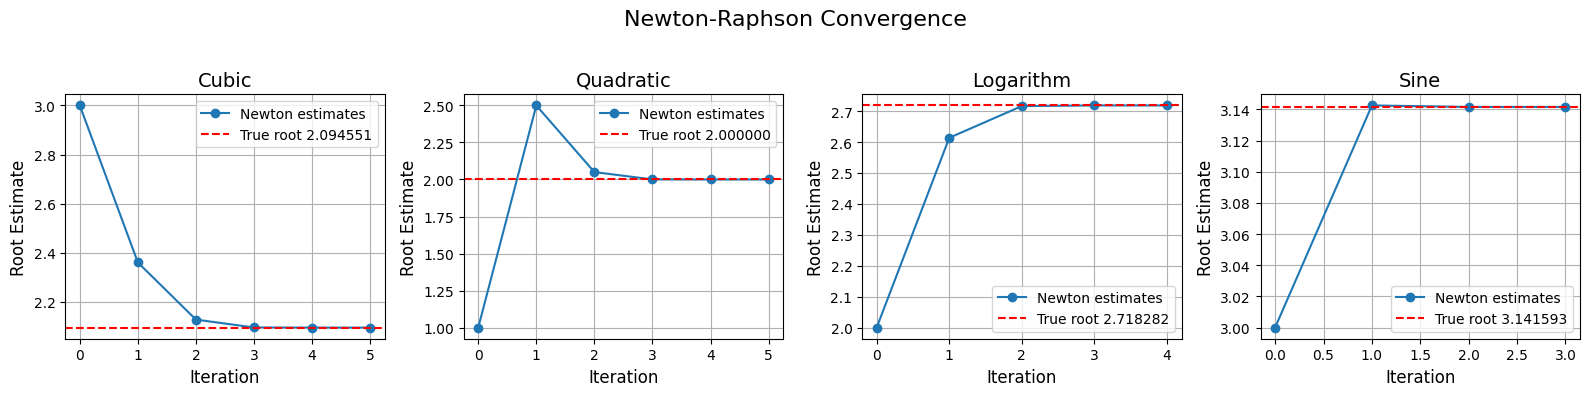

In [7]:
test_funcs = [
    ("Cubic", 3.0),
    ("Quadratic", 1.0),
    ("Logarithm", 2.0),
    ("Sine", 3.0),
]

roots = []
true_roots = []
labels = []

for label, x0 in test_funcs:
    f = func_map[label]
    df = derivative_map[label]

    # Compute the true root using scipy newton
    root = NewtonRaphson1D()(func=f, x0=x0, derivative=df)
    true_root = newton(func=f, x0=x0, fprime=df)

    roots.append(root)
    true_roots.append(true_root)
    labels.append(label)

plot_convergence(roots, true_roots, labels)